## Hermite-KAN for MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from HermiteKANLayer import HermiteKANLayer

In [2]:
# Construct a HermiteKAN for MNIST
class MNISTHermiteKAN(nn.Module):
    def __init__(self):
        super(MNISTHermiteKAN, self).__init__()
        self.hermitekan1 = HermiteKANLayer(28*28, 32, 4)
        self.ln1 = nn.LayerNorm(32) # To avoid gradient vanishing caused by tanh
        self.hermitekan2 = HermiteKANLayer(32, 16, 4)
        self.ln2 = nn.LayerNorm(16)
        self.hermitekan3 = HermiteKANLayer(16, 10, 4)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.hermitekan1(x)
        x = self.ln1(x)
        x = self.hermitekan2(x)
        x = self.ln2(x)
        x = self.hermitekan3(x)
        return x

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNISTHermiteKAN().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

criterion = nn.CrossEntropyLoss()

# LBFGS is really slow
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Adam works with very low lr
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        if isinstance(optimizer, optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            
        total_loss += loss
        
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

Total trainable parameters: 128896


Epoch 1, Train Loss: 0.4476, Test Loss: 0.2289, Test Acc: 0.93
Epoch 2, Train Loss: 0.1952, Test Loss: 0.1593, Test Acc: 0.95
Epoch 3, Train Loss: 0.1535, Test Loss: 0.1848, Test Acc: 0.94
Epoch 4, Train Loss: 0.1256, Test Loss: 0.1318, Test Acc: 0.96
Epoch 5, Train Loss: 0.1109, Test Loss: 0.1321, Test Acc: 0.96
Epoch 6, Train Loss: 0.0971, Test Loss: 0.1284, Test Acc: 0.96
Epoch 7, Train Loss: 0.0902, Test Loss: 0.1127, Test Acc: 0.97
Epoch 8, Train Loss: 0.0775, Test Loss: 0.1324, Test Acc: 0.96
Epoch 9, Train Loss: 0.0726, Test Loss: 0.1250, Test Acc: 0.96
Epoch 10, Train Loss: 0.0628, Test Loss: 0.1139, Test Acc: 0.97
Epoch 11, Train Loss: 0.0592, Test Loss: 0.1217, Test Acc: 0.96
Epoch 12, Train Loss: 0.0520, Test Loss: 0.1141, Test Acc: 0.97
Epoch 13, Train Loss: 0.0503, Test Loss: 0.1161, Test Acc: 0.97
Epoch 14, Train Loss: 0.0453, Test Loss: 0.1187, Test Acc: 0.97
Epoch 15, Train Loss: 0.0405, Test Loss: 0.1240, Test Acc: 0.97
Epoch 16, Train Loss: 0.0407, Test Loss: 0.1208, 

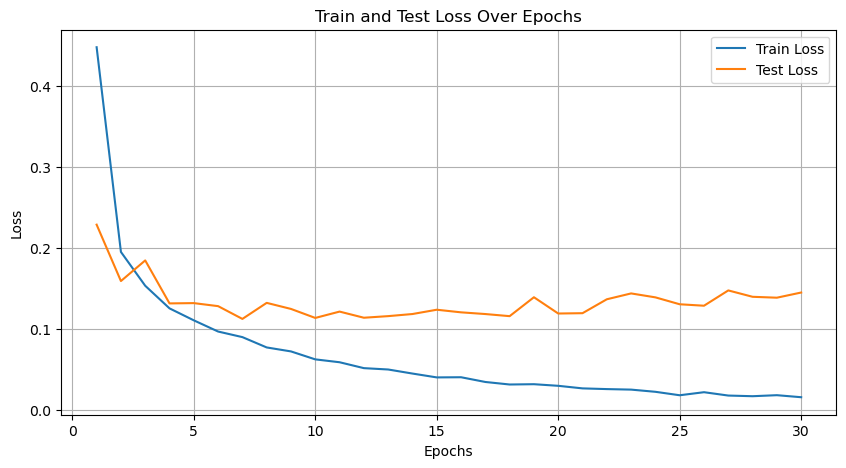

In [4]:
train_losses = []
test_losses = []

epochs = 30
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Take a peek at what the Hermite Polynomials look like

In [5]:
def hermite_polynomials(x, degree):
    # Base cases for H_0(x) and H_1(x)
    if degree == 0:
        return np.ones_like(x)
    elif degree == 1:
        return 2 * x

    # Initial values for H_0(x) and H_1(x)
    Hn_2 = np.ones_like(x)  # H_0(x)
    Hn_1 = 2 * x           # H_1(x)
    Hn = None

    # Compute Hermite polynomials using the recurrence relation
    for n in range(1, degree):
        Hn = 2 * x * Hn_1 - 2 * n * Hn_2
        Hn_2, Hn_1 = Hn_1, Hn  # Update values for the next iteration

    return Hn



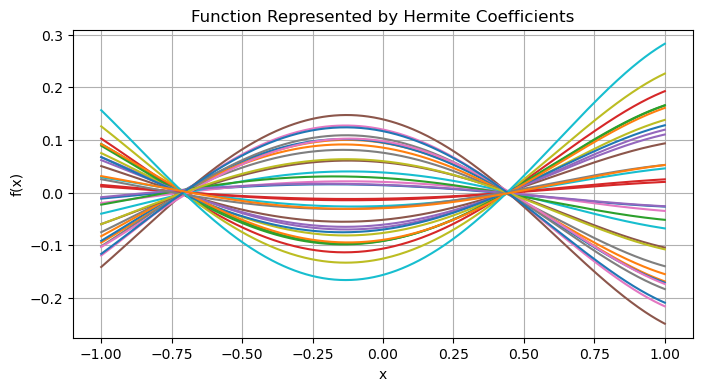

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.hermitekan1.hermite_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[28 * 28 // 2]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * hermite_polynomials(x_values, i)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Hermite Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

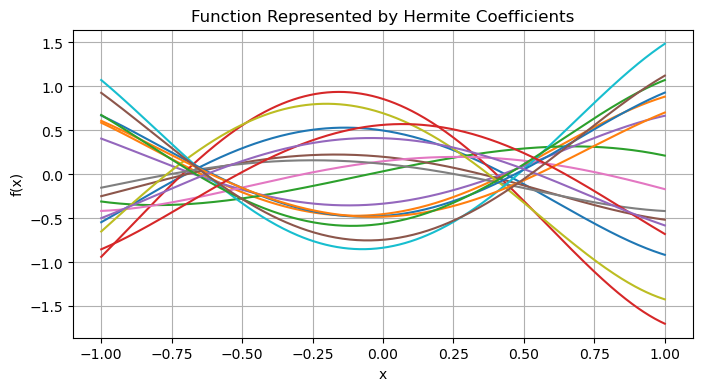

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.hermitekan2.hermite_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[16]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * hermite_polynomials(x_values, i)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Hermite Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

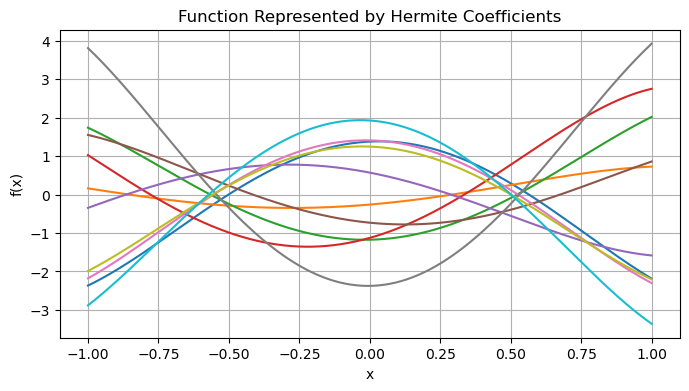

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.hermitekan3.hermite_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[8]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * hermite_polynomials(x_values, i)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Hermite Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()